## Computer-Aided Melanoma detection using machine learning techniques

## Transfer Learning

### 1. Preprocessing

Importing the libraries

In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten 
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import GlobalAveragePooling2D
from keras.utils import to_categorical
from keras import backend as K
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import argparse
import random
import pickle
import keras
import cv2
import os

Using TensorFlow backend.


In [2]:
path = "C:\\Users\\mreun\\Moles"

In [3]:
# Let's define the size of imported images
height = 256
width = 256

epoch = 15 #epoch number for training the model

In [4]:
# Initializing data and labels
data = []
labels = []

In [5]:
imagePaths = sorted(list(paths.list_images(path)))
random.seed(42)
random.shuffle(imagePaths)

In [6]:
# Cycle for downloading images
for imagePath in imagePaths:
    # loading image, changing the size to 64x64 pixels 
    # adding to the list
    image = cv2.imread(imagePath)
    image = np.array(cv2.resize(image, (height, width)))
    data.append(image)

    # retrieving the label from the path 
    # adding to the list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [7]:
# normalizing pixels to the range from 0 to 1
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [9]:
# transforming labels into 0 and 1 and then to vectors

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
num_classes = y_test.shape[1]
num_pixels = X_train[0].shape[0] * X_train[0].shape[1] * X_train[0].shape[2] # find size of one-dimensional vector

In [11]:
data.shape

(5335, 256, 256, 3)

### 2. Training the model

#### Inception

In [12]:
def inception_architecture():

    from keras.applications.inception_v3 import InceptionV3

    # Pre-build model
    base_model = InceptionV3(include_top = False, weights = None, input_shape = (height, width, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 2, activation = 'softmax')(x)

    # Creating the model
    inception_model = Model(base_model.input, output)
    
    # Compiling the model
    inception_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])
    
    return inception_model

In [13]:
inception_model = inception_architecture()

In [14]:
checkpointer = ModelCheckpoint(filepath='Saved_models/weights.best.inception.hdf5', 
                               verbose=1, 
                               save_best_only=True)

History_incep = inception_model.fit(X_train, y_train, 
                    batch_size = 8,
                    validation_data = (X_test, y_test),
                    epochs = epoch,
                    callbacks=[checkpointer], 
                    verbose=1)

# evaluate the model
scores = inception_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

Train on 4268 samples, validate on 1067 samples
Epoch 1/15
4268/4268 [==============================] - 2165s 507ms/step - loss: 0.6583 - accuracy: 0.6518 - val_loss: 0.6104 - val_accuracy: 0.6720

Epoch 00001: val_loss improved from inf to 0.61042, saving model to Saved_models/weights.best.inception.hdf5
Epoch 2/15
4268/4268 [==============================] - 2204s 516ms/step - loss: 0.5977 - accuracy: 0.6645 - val_loss: 0.6179 - val_accuracy: 0.6354

Epoch 00002: val_loss did not improve from 0.61042
Epoch 3/15
4268/4268 [==============================] - 2203s 516ms/step - loss: 0.5795 - accuracy: 0.6884 - val_loss: 0.5926 - val_accuracy: 0.7320

Epoch 00003: val_loss improved from 0.61042 to 0.59260, saving model to Saved_models/weights.best.inception.hdf5
Epoch 4/15
4268/4268 [==============================] - 2192s 514ms/step - loss: 0.5333 - accuracy: 0.7165 - val_loss: 0.4795 - val_accuracy: 0.7591

Epoch 00004: val_loss improved from 0.59260 to 0.47949, saving model to Saved_m

In [15]:
# Loading the weights
inception_model.load_weights("./Saved_models/weights.best.inception.hdf5")

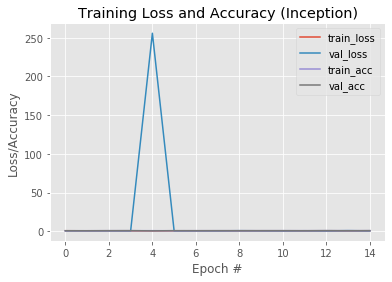

In [16]:
N = np.arange(0, epoch)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, History_incep.history["loss"], label="train_loss")
plt.plot(N, History_incep.history["val_loss"], label="val_loss")
plt.plot(N, History_incep.history["accuracy"], label="train_acc")
plt.plot(N, History_incep.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Inception)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#### MobileNet

In [14]:
def mobilenet_architecture():

    from keras.applications.mobilenet import MobileNet

    # Pre-build model
    base_model = MobileNet(include_top = False, weights = None, input_shape = (height, width, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 2, activation = 'softmax')(x)

    # Creating the model
    mobilenet_model = Model(base_model.input, output)
     
    # Compiling the model
    mobilenet_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])

    return mobilenet_model

In [15]:
mobilenet_model = mobilenet_architecture()

In [16]:
checkpointer = ModelCheckpoint(filepath='Saved_models/weights.best.mobilenet.hdf5', 
                               verbose=1, 
                               save_best_only=True)

In [29]:
History_mobnet = mobilenet_model.fit(X_train, y_train, 
                    batch_size = 8,
                    validation_data = (X_test, y_test),
                    epochs = epoch,
                    callbacks=[checkpointer], 
                    verbose=1)

# evaluate the model
scores = mobilenet_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

Train on 4268 samples, validate on 1067 samples
Epoch 1/15
4268/4268 [==============================] - 1531s 359ms/step - loss: 0.5825 - accuracy: 0.6914 - val_loss: 1.9603 - val_accuracy: 0.5773

Epoch 00001: val_loss improved from inf to 1.96031, saving model to Saved_models/weights.best.mobilenet.hdf5
Epoch 2/15
4268/4268 [==============================] - 1471s 345ms/step - loss: 0.5307 - accuracy: 0.7240 - val_loss: 0.4556 - val_accuracy: 0.7601

Epoch 00002: val_loss improved from 1.96031 to 0.45564, saving model to Saved_models/weights.best.mobilenet.hdf5
Epoch 3/15
4268/4268 [==============================] - 1303s 305ms/step - loss: 0.5342 - accuracy: 0.7205 - val_loss: 0.4708 - val_accuracy: 0.7563

Epoch 00003: val_loss did not improve from 0.45564
Epoch 4/15
4268/4268 [==============================] - 1215s 285ms/step - loss: 0.5097 - accuracy: 0.7359 - val_loss: 0.6079 - val_accuracy: 0.7376

Epoch 00004: val_loss did not improve from 0.45564
Epoch 5/15
4268/4268 [======

NameError: name 'mibilenet_model' is not defined

In [31]:
# evaluate the model
scores = mobilenet_model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

1067/1067 [==============================] - 131s 123ms/step
Accuracy: 0.7891284227371216 
 Error: 21.087157726287842


In [32]:
# Loading the weights
mobilenet_model.load_weights("./Saved_models/weights.best.mobilenet.hdf5")

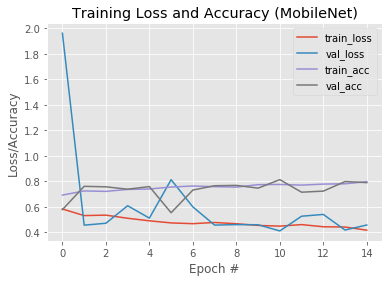

In [33]:
N = np.arange(0, epoch)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, History_mobnet.history["loss"], label="train_loss")
plt.plot(N, History_mobnet.history["val_loss"], label="val_loss")
plt.plot(N, History_mobnet.history["accuracy"], label="train_acc")
plt.plot(N, History_mobnet.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (MobileNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Xception

In [16]:
def xception_architecture():

    from keras.applications.xception import Xception

    # Pre-build model
    base_model = Xception(include_top = False, weights = None, input_shape = (height, width, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 2, activation = 'softmax')(x)

    # Creating the model
    xception_model = Model(base_model.input, output)
    
    # Compiling the model
    xception_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

    return xception_model

In [17]:
xception_model = xception_architecture()

In [14]:
#tensor_board = TensorBoard(log_dir='./logs', histogram_freq = 0, batch_size = 8)

checkpointer = ModelCheckpoint(filepath='Saved_models/weights.best.xception.hdf5', 
                               verbose=1, 
                               save_best_only=True)

History_xcept = xception_model.fit(X_train, y_train, 
                   batch_size = 8,
                   validation_data = (X_test, y_test),
                    epochs = epoch,
                   callbacks=[checkpointer], 
                   verbose=1)

# evaluate the model
scores = xception_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

Train on 4268 samples, validate on 1067 samples
Epoch 1/15
4268/4268 [==============================] - 4022s 942ms/step - loss: 0.6165 - accuracy: 0.6797 - val_loss: 0.5219 - val_accuracy: 0.7245

Epoch 00001: val_loss improved from inf to 0.52193, saving model to Saved_models/weights.best.xception.hdf5
Epoch 2/15
4268/4268 [==============================] - 3968s 930ms/step - loss: 0.5350 - accuracy: 0.7289 - val_loss: 4.5816 - val_accuracy: 0.6617

Epoch 00002: val_loss did not improve from 0.52193
Epoch 3/15
4268/4268 [==============================] - 3909s 916ms/step - loss: 0.5259 - accuracy: 0.7249 - val_loss: 3.2508 - val_accuracy: 0.4714

Epoch 00003: val_loss did not improve from 0.52193
Epoch 4/15
4268/4268 [==============================] - 3931s 921ms/step - loss: 0.5241 - accuracy: 0.7275 - val_loss: 1.0779 - val_accuracy: 0.5914

Epoch 00004: val_loss did not improve from 0.52193
Epoch 5/15
4268/4268 [==============================] - 3957s 927ms/step - loss: 0.4933 - a

In [15]:
# Loading the weights
xception_model.load_weights("./Saved_models/weights.best.xception.hdf5")

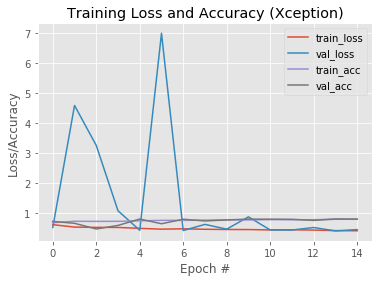

In [16]:
N = np.arange(0, epoch)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, History_xcept.history["loss"], label="train_loss")
plt.plot(N, History_xcept.history["val_loss"], label="val_loss")
plt.plot(N, History_xcept.history["accuracy"], label="train_acc")
plt.plot(N, History_xcept.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Xception)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## 3. Prediction

In [19]:
model_architecture = mobilenet_architecture()
weight_path = "./Saved_models/weights.best.mobilenet.hdf5"

In [20]:
# Let's upload test set the same way as it was done for training
path_test = "C:\\Users\\mreun\\Test"

In [21]:
imagePaths_test = sorted(list(paths.list_images(path_test)))

In [22]:
data_test = []
label_test = []

In [23]:
for imagePath in imagePaths_test:

    image = cv2.imread(imagePath)
    image = np.array(cv2.resize(image, (height, width)))
    data_test.append(image)

    label = imagePath.split(os.path.sep)[-2]
    label_test.append(label)

In [24]:
data_test = np.array(data_test, dtype="float") / 255.0
label_test = np.array(label_test)

In [25]:
predictions = []

In [26]:
def predict(image, 
            model_architecture = model_architecture, 
            path_model_weight = weight_path):

    # Getting the model's architecture
    model = model_architecture
    # Loading the weights from the file
    model.load_weights(path_model_weight)
    # Predicting
    pred = model.predict(image)
    for_df = [pred[0][0], pred[0][1]]
    predictions.append(for_df)
    if np.argmax(pred) == 0:
        return [1., 0.]
    elif np.argmax(pred) == 1:
        return [0., 1.]

In [27]:
y_test_pred = lb.transform(label_test)
y_true = to_categorical(y_test_pred)

number_test = len(data_test)

## 4. Evaluating the model

In [28]:
def compute_roc(y_true, y_score):
    
    # Computing ROC curve and area
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_score) 
    auroc = auc(false_positive_rate, true_positive_rate) 
    return false_positive_rate, true_positive_rate, auroc

In [29]:
def plot_roc(y_true, y_score):

    # Ploting ROC curve
 
    false_positive_rate, true_positive_rate, auroc = compute_roc(y_true, y_score)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.plot(false_positive_rate, 
             true_positive_rate, 
             color='darkorange',
             lw=2, 
             label='ROC curve (area = {:.2f})'.format(auroc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic example', fontsize=15)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()
    
plt.style.use("seaborn-white")

#### Inception

In [30]:
weight_path = "./Saved_models/weights.best.inception.hdf5"

In [31]:
y_score_incep = []
for index in range(number_test):
    probs = predict(image = np.expand_dims(data_test[index], axis=0), model_architecture = inception_model, 
            path_model_weight = weight_path)
    y_score_incep.append(probs)
    
correct = np.array(y_true) == np.array(y_score_incep)

In [32]:
df_correct = pd.DataFrame(y_score_incep, columns = ["Non-melanoma_real","Melanoma_real"])
df_prediction_incep = pd.DataFrame(predictions, columns = ["Non-melanoma_prediction","Melanoma_prediction"])
df_merged=pd.concat([df_correct, df_prediction_incep],axis=1)

In [33]:
df_merged.head(10)

,Non-melanoma_real,Melanoma_real,Non-melanoma_prediction,Melanoma_prediction
0,1.0,0.0,0.995989,0.004011
1,1.0,0.0,0.996629,0.003371
2,0.0,1.0,0.173423,0.826577
3,1.0,0.0,0.990497,0.009503
4,1.0,0.0,0.994566,0.005434
5,1.0,0.0,0.994781,0.005219
6,1.0,0.0,0.993788,0.006212
7,1.0,0.0,0.651891,0.348110
8,1.0,0.0,0.994770,0.005229
9,1.0,0.0,0.641486,0.358514


In [34]:
print("Accuracy = %2.2f%%" % (np.mean(correct)*100))

Accuracy = 81.50%


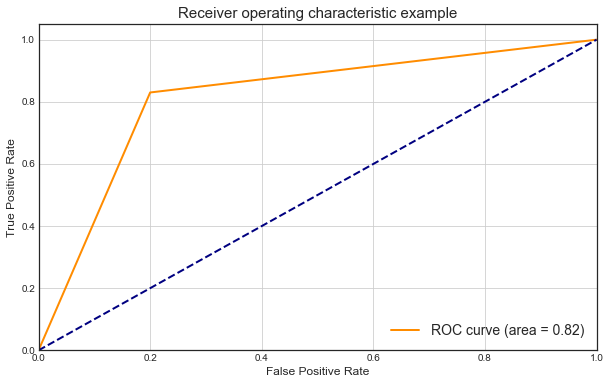

In [35]:
# Re-ordering the actual y (for ROC)
y_true_2 = []
for i in range(len(y_true)):
    y_true_2.append(y_true[i][0])
    
y_score_2 = []
for i in range(len(y_score_incep)):
    y_score_2.append(y_score_incep[i][0])

plot_roc(y_true_2, y_score_2)

In [36]:
def positive_negative_measurement(y_true, y_score_incep):
    # Initialization
    TRUE_POSITIVE = 0
    FALSE_POSITIVE = 0
    TRUE_NEGATIVE = 0
    FALSE_NEGATIVE = 0
    
    # Calculating the model
    for i in range(len(y_score_incep)):
        if y_true[i] == y_score_incep[i] == 1:
            TRUE_POSITIVE += 1
        if (y_score_incep[i] == 1) and (y_true[i] != y_score_incep[i]):
            FALSE_POSITIVE += 1
        if y_true[i] == y_score_incep[i] == 0:
            TRUE_NEGATIVE += 1
        if (y_score_incep[i] == 0) and (y_true[i] != y_score_incep[i]):
            FALSE_NEGATIVE += 1

    return(TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE)

In [37]:
TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = positive_negative_measurement(y_true_2, y_score_2)
postives_negatives = [[TRUE_POSITIVE, FALSE_POSITIVE], 
                      [FALSE_NEGATIVE, TRUE_NEGATIVE]]

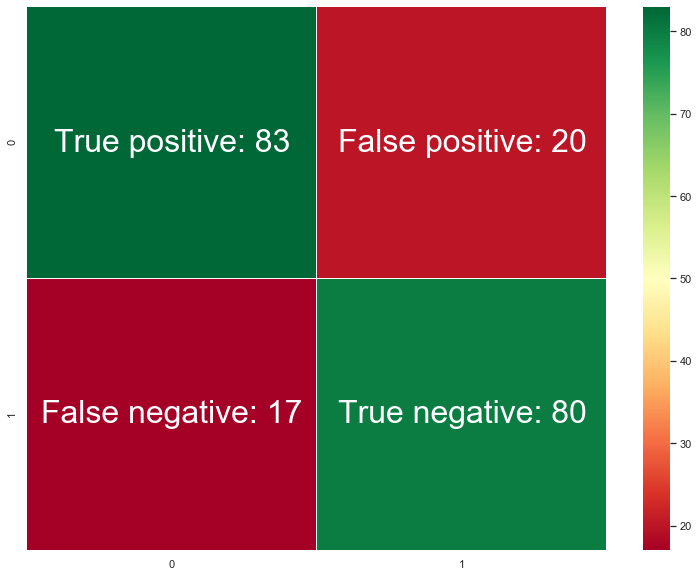

In [38]:
import seaborn as sns
sns.set()
labels =  np.array([['True positive: ' + str(TRUE_POSITIVE),
                     'False positive: ' + str(FALSE_POSITIVE)],
                    ['False negative: ' + str(FALSE_NEGATIVE),
                     'True negative: ' + str(TRUE_NEGATIVE)]])
plt.figure(figsize = (13, 10))
sns.heatmap(postives_negatives, annot = labels, linewidths = 0.1, fmt="", cmap = 'RdYlGn', annot_kws={"size":32})

In [39]:
sensitivity = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)
specifity = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
precision = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)
accuracy = (TRUE_POSITIVE + TRUE_NEGATIVE) / (TRUE_POSITIVE + FALSE_POSITIVE + TRUE_NEGATIVE + FALSE_NEGATIVE)
name = "Inception"
scores_incep = [name, sensitivity, specifity, precision, accuracy]

In [40]:
df_scores_incep = pd.DataFrame([scores_incep], columns = ["Model",  "Sensitivity",  "Specifity",  "Precision", "Accuracy"])
df_scores_incep

,Model,Sensitivity,Specifity,Precision,Accuracy
0,Inception,0.83,0.824742,0.805825,0.815


#### MobileNet

In [41]:
weight_path = "./Saved_models/weights.best.mobilenet.hdf5"

In [42]:
y_score_mobnet = []
for index in range(number_test):
    probs = predict(image = np.expand_dims(data_test[index], axis=0), model_architecture = mobilenet_model, 
            path_model_weight = weight_path)
    y_score_mobnet.append(probs)
    
correct = np.array(y_true) == np.array(y_score_mobnet)

In [43]:
df_correct = pd.DataFrame(y_score_mobnet, columns = ["Non-melanoma_real","Melanoma_real"])
df_prediction_mobnet = pd.DataFrame(predictions, columns = ["Non-melanoma_prediction","Melanoma_prediction"])
df_merged=pd.concat([df_correct, df_prediction_mobnet],axis=1)

In [44]:
df_merged.head(10)

,Non-melanoma_real,Melanoma_real,Non-melanoma_prediction,Melanoma_prediction
0,1.0,0.0,0.995989,0.004011
1,1.0,0.0,0.996629,0.003371
2,0.0,1.0,0.173423,0.826577
3,1.0,0.0,0.990497,0.009503
4,1.0,0.0,0.994566,0.005434
5,1.0,0.0,0.994781,0.005219
6,1.0,0.0,0.993788,0.006212
7,1.0,0.0,0.651891,0.348110
8,1.0,0.0,0.994770,0.005229
9,1.0,0.0,0.641486,0.358514


In [45]:
print("Accuracy = %2.2f%%" % (np.mean(correct)*100))

Accuracy = 74.50%


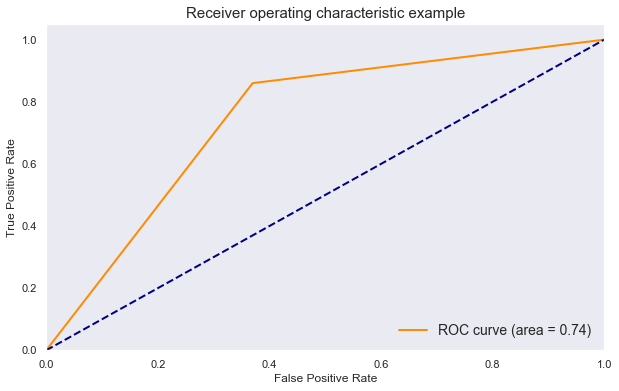

In [46]:
# Re-ordering the actual y (for ROC)
y_true_2 = []
for i in range(len(y_true)):
    y_true_2.append(y_true[i][0])
    
y_score_2 = []
for i in range(len(y_score_mobnet)):
    y_score_2.append(y_score_mobnet[i][0])

plot_roc(y_true_2, y_score_2)

In [47]:
def positive_negative_measurement(y_true, y_score_mobnet):
    # Initialization
    TRUE_POSITIVE = 0
    FALSE_POSITIVE = 0
    TRUE_NEGATIVE = 0
    FALSE_NEGATIVE = 0
    
    # Calculating the model
    for i in range(len(y_score_mobnet)):
        if y_true[i] == y_score_mobnet[i] == 1:
            TRUE_POSITIVE += 1
        if (y_score_mobnet[i] == 1) and (y_true[i] != y_score_mobnet[i]):
            FALSE_POSITIVE += 1
        if y_true[i] == y_score_mobnet[i] == 0:
            TRUE_NEGATIVE += 1
        if (y_score_mobnet[i] == 0) and (y_true[i] != y_score_mobnet[i]):
            FALSE_NEGATIVE += 1

    return(TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE)

In [48]:
TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = positive_negative_measurement(y_true_2, y_score_2)
postives_negatives = [[TRUE_POSITIVE, FALSE_POSITIVE], 
                      [FALSE_NEGATIVE, TRUE_NEGATIVE]]

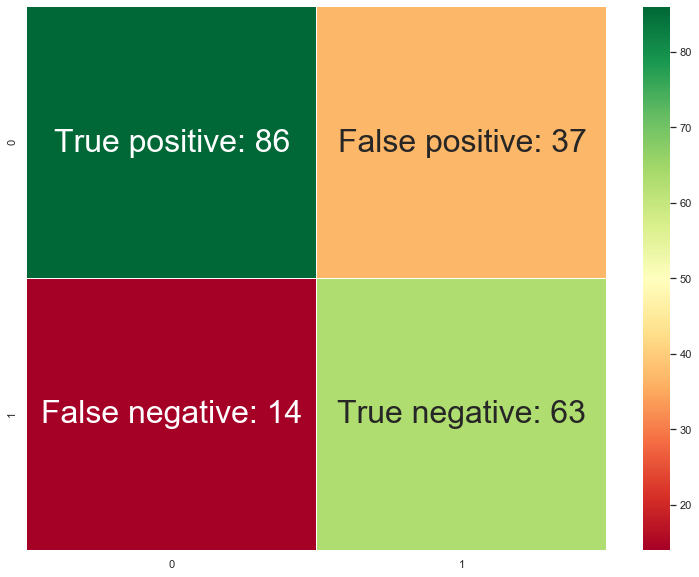

In [49]:
import seaborn as sns
sns.set()
labels =  np.array([['True positive: ' + str(TRUE_POSITIVE),
                     'False positive: ' + str(FALSE_POSITIVE)],
                    ['False negative: ' + str(FALSE_NEGATIVE),
                     'True negative: ' + str(TRUE_NEGATIVE)]])
plt.figure(figsize = (13, 10))
sns.heatmap(postives_negatives, annot = labels, linewidths = 0.1, fmt="", cmap = 'RdYlGn', annot_kws={"size":32})

In [50]:
sensitivity = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)
specifity = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
precision = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)
accuracy = (TRUE_POSITIVE + TRUE_NEGATIVE) / (TRUE_POSITIVE + FALSE_POSITIVE + TRUE_NEGATIVE + FALSE_NEGATIVE)
name = "MobileNet"
scores_mob = [name, sensitivity, specifity, precision, accuracy]

In [51]:
df_scores_mob = pd.DataFrame([scores_mob], columns = ["Model",  "Sensitivity",  "Specifity",  "Precision", "Accuracy"])
df_scores_mob

,Model,Sensitivity,Specifity,Precision,Accuracy
0,MobileNet,0.86,0.818182,0.699187,0.745


#### Xception

In [52]:
weight_path = 'Saved_models/weights.best.xception.hdf5'

In [53]:
y_score_xcep = []
for index in range(number_test): #compute one at a time due to memory constraints
    probs = predict(image = np.expand_dims(data_test[index], axis=0), model_architecture = xception_model, 
            path_model_weight = weight_path)
    y_score_xcep.append(probs)
    
correct = np.array(y_true) == np.array(y_score_xcep)

In [54]:
df_correct = pd.DataFrame(y_score_xcep, columns = ["Non-melanoma_real","Melanoma_real"])
df_prediction_xcep = pd.DataFrame(predictions, columns = ["Non-melanoma_prediction","Melanoma_prediction"])
df_merged=pd.concat([df_correct, df_prediction_xcep],axis=1)

In [55]:
df_merged.head(10)

,Non-melanoma_real,Melanoma_real,Non-melanoma_prediction,Melanoma_prediction
0,1.0,0.0,0.995989,0.004011
1,1.0,0.0,0.996629,0.003371
2,1.0,0.0,0.173423,0.826577
3,0.0,1.0,0.990497,0.009503
4,1.0,0.0,0.994566,0.005434
5,1.0,0.0,0.994781,0.005219
6,1.0,0.0,0.993788,0.006212
7,1.0,0.0,0.651891,0.348110
8,1.0,0.0,0.994770,0.005229
9,1.0,0.0,0.641486,0.358514


In [56]:
print("Accuracy = %2.2f%%" % (np.mean(correct)*100))

Accuracy = 78.50%


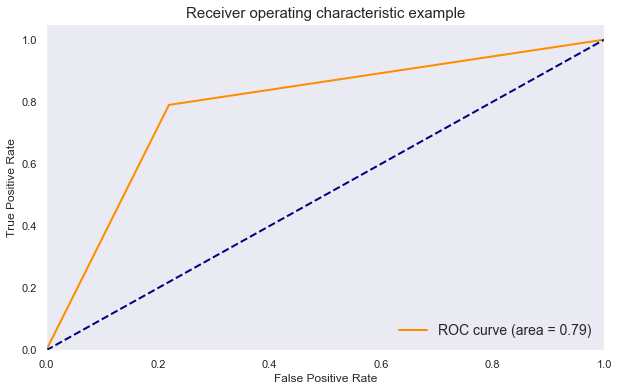

In [57]:
# Re-ordering the actual y (for ROC)
y_true_2 = []
for i in range(len(y_true)):
    y_true_2.append(y_true[i][0])
    
y_score_2 = []
for i in range(len(y_score_xcep)):
    y_score_2.append(y_score_xcep[i][0])

plot_roc(y_true_2, y_score_2)

In [58]:
def positive_negative_measurement(y_true, y_score_xcep):
    # Initialization
    TRUE_POSITIVE = 0
    FALSE_POSITIVE = 0
    TRUE_NEGATIVE = 0
    FALSE_NEGATIVE = 0
    
    # Calculating the model
    for i in range(len(y_score_xcep)):
        if y_true[i] == y_score_xcep[i] == 1:
            TRUE_POSITIVE += 1
        if (y_score_xcep[i] == 1) and (y_true[i] != y_score_xcep[i]):
            FALSE_POSITIVE += 1
        if y_true[i] == y_score_xcep[i] == 0:
            TRUE_NEGATIVE += 1
        if (y_score_xcep[i] == 0) and (y_true[i] != y_score_xcep[i]):
            FALSE_NEGATIVE += 1

    return(TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE)

In [59]:
TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = positive_negative_measurement(y_true_2, y_score_2)
postives_negatives = [[TRUE_POSITIVE, FALSE_POSITIVE], 
                      [FALSE_NEGATIVE, TRUE_NEGATIVE]]

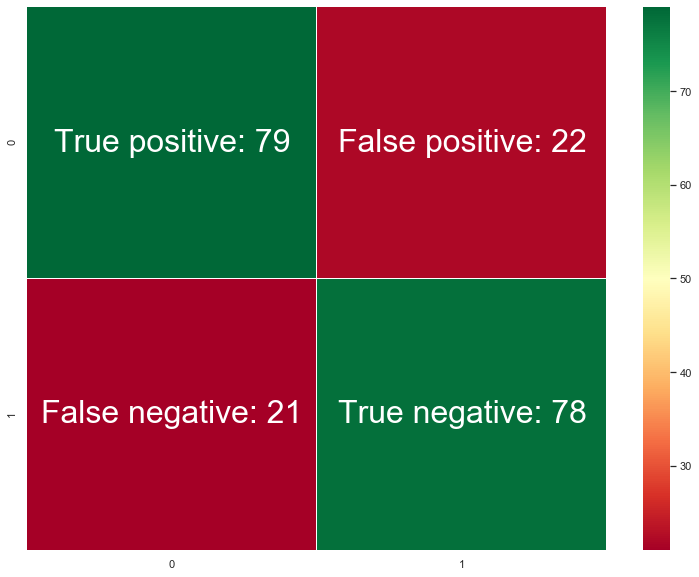

In [60]:
import seaborn as sns
sns.set()
labels =  np.array([['True positive: ' + str(TRUE_POSITIVE),
                     'False positive: ' + str(FALSE_POSITIVE)],
                    ['False negative: ' + str(FALSE_NEGATIVE),
                     'True negative: ' + str(TRUE_NEGATIVE)]])
plt.figure(figsize = (13, 10))
sns.heatmap(postives_negatives, annot = labels, linewidths = 0.1, fmt="", cmap = 'RdYlGn', annot_kws={"size":32})

In [61]:
sensitivity = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)
specifity = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
precision = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)
accuracy = (TRUE_POSITIVE + TRUE_NEGATIVE) / (TRUE_POSITIVE + FALSE_POSITIVE + TRUE_NEGATIVE + FALSE_NEGATIVE)
name = "Xception"
scores_xcep = [name, sensitivity, specifity, precision, accuracy]

In [62]:
df_scores_xcep = pd.DataFrame([scores_xcep], columns = ["Model",  "Sensitivity",  "Specifity",  "Precision", "Accuracy"])

In [63]:
scores_SNN = ['SNN', 0.9, 0.84127, 0.656934, 0.715]

In [64]:
df_scores_SNN = pd.DataFrame([scores_SNN], columns = ["Model",  "Sensitivity",  "Specifity",  "Precision", "Accuracy"])

In [65]:
scores_CNN = ["CNN", 0.83, 0.7875, 0.691667, 0.73]

In [66]:
df_scores_CNN = pd.DataFrame([scores_CNN], columns = ["Model",  "Sensitivity",  "Specifity",  "Precision", "Accuracy"])

In [67]:
df_scores = pd.concat([df_scores_SNN, df_scores_CNN, df_scores_incep, df_scores_mob, df_scores_xcep],axis=0)

In [68]:
df_scores

,Model,Sensitivity,Specifity,Precision,Accuracy
0,SNN,0.90,0.841270,0.656934,0.715
0,CNN,0.83,0.787500,0.691667,0.730
0,Inception,0.83,0.824742,0.805825,0.815
0,MobileNet,0.86,0.818182,0.699187,0.745
0,Xception,0.79,0.787879,0.782178,0.785
